In [1]:
! pip install networkx
! pip install plotly
! pip install colorlover
! pip install colour

In [2]:
import pandas as pd
import networkx as nx
import random
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.graph_objects as go
init_notebook_mode(connected=True)
from colour import Color
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.data import find
import nltk
from collections import Counter
nltk.download('stopwords')
import colorlover as cl
from IPython.display import HTML
import operator

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Q1. Choose a hash-tag

In [0]:
df = pd.read_csv("tweets2009-06-0115.csv.zip", sep='\t', compression='zip')

In [0]:
obamaTag = df[df["tweet"].str.lower().str.contains("#obama", na=False)].copy()

In [0]:
def addMentionedColumn(df):
    
    def mentionsList(txt):
        allWords = [word.strip(""" ,.:'\";""").lower() for word in txt.split()]
        allNames = [word.strip("@") for word in allWords if word.startswith("@")]
        uniqueNames = list(set(allNames))
        return allNames
    
    df["mentioned"] = df["tweet"].apply(mentionsList)

In [0]:
addMentionedColumn(obamaTag)

In [9]:
obamaTag

,date,user,tweet,mentioned
5508,2009-06-11 17:07:55,chrisspangle,RT @LPIN Czar you Serious!?: Obama has appoint...,[lpin]
6099,2009-06-11 17:08:28,harrisonwfrv5,I give you President Barack Obama. #obamagb ht...,[]
7502,2009-06-11 17:10:14,karenredshoespr,Guys on the lookout! #obamagb http://twitpic.c...,[]
8661,2009-06-11 17:11:12,scott_spiegel,Five Questions for Sotomayor - http://tinyurl....,[]
9793,2009-06-11 17:12:20,ksoileau,czar-chasm: The czars yet to be named. #czarti...,[]
...,...,...,...,...
3415008,2009-06-14 23:27:46,barackproblema,RT @FreezeDriedNews @dcjc RT @USAMIA: White Ho...,"[freezedriednews, dcjc, usamia]"
3417831,2009-06-14 23:31:27,docgotham,"http://twitpic.com/7eeih - ""the PacMan sticker...",[cyanatrendland)]
3424158,2009-06-14 23:40:33,twinelm,"RT @USAMIA Drill here, drill now ,and drill of...",[usamia]
3429372,2009-06-14 23:48:29,obamainthenews,USA Today: Obama welcomes Netanyahu's two-stat...,[]


# Q2. Build a Mention Graph

In [0]:
def mentionGraph(df):
    g = nx.Graph()
    
    for (index, date, user, tweet, mentionedUsers) in df.itertuples():
        for mentionedUser in mentionedUsers:
            if (user in g) and (mentionedUser in g[user]):
                g[user][mentionedUser]["numberMentions"] += 1
            else:
                g.add_edge(user, mentionedUser, numberMentions=1)
    
    return g

In [0]:
obamaGraph = mentionGraph(obamaTag)

## (a) How many nodes and how many edges in your mention graph?


In [0]:
print("# nodes:", len(obamaGraph.nodes()))
print("# edges:", len(obamaGraph.edges()))

# nodes: 320
# edges: 237


## (b) Build a histogram of the graph nodes’ degree (i.e., the degree distribution of the graph). What can you learn from the degree distribution?

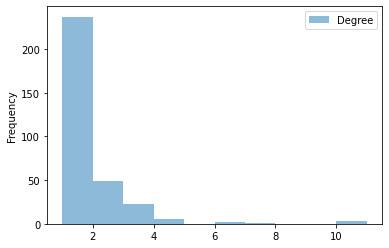

In [0]:
G = pd.DataFrame(list(nx.degree(obamaGraph)), columns = ['Node' , 'Degree'])
G.plot.hist(bins=10,alpha=0.5)

Most of the nodes have a degree of 1. This means that the majority of users are linked to one other user.

## (c) Provide a list of top 5 edges with highest weights (edges are identified be the two nodes they connects, e.g., ⟨node1, node2⟩).

In [0]:
def weight_dict(G):
    weight_dict = {}
    for (u,v) in G.edges():
        edgeWidth = G[u][v]['numberMentions']
        weight_dict[(u,v)] = edgeWidth
    return weight_dict

obama_edge_dict = weight_dict(obamaGraph)

In [0]:
top_5_edge = sorted(obama_edge_dict.items(), key=lambda x: -x[1])[:5]

In [0]:
top_5_edge

[(('dcjc', 'usamia'), 5),
 (('ruqru', 'decided1'), 4),
 (('suhrmesa', 'jaketapper'), 3),
 (('usamia', 'stwood1953'), 3),
 (('suhrmesa', 'majoratwh'), 2)]

## (d) Provide a visualization of the mention graph in which the edge color reflects its weight (i.e., the number of mentions).

In [0]:
def addRandomPositions(graph):
    posDict = dict((node,(random.gauss(0,10),random.gauss(0,10))) for node in graph.nodes())
    nx.set_node_attributes(graph, name="pos", values=posDict)

In [0]:
addRandomPositions(obamaGraph)

In [0]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [0]:
def plotColorNetwork(graph):
    scatters=[]

    maxMention = max(weight_dict(graph).values())
    minMention = min(weight_dict(graph).values())

    for (node1, node2) in graph.edges():
        x0, y0 = graph.nodes[node1]['pos']
        x1, y1 = graph.nodes[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        red = Color('red')
        #color spectrum from width = 1 (red) to width = 5 (green)
        colors = ['white', 'red', '#cca300', '#8fb300', '#3d9900', 'green']
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=scatter.Line(width=1 ,color=colors[edgeWidth]))
        scatters.append(s)



    for node in graph.nodes():
        xPos, yPos = graph.nodes[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                hoverinfo='none',
                mode='markers', 
                marker=dict(
                    color="#888", 
                    size=10,         
                    line=dict(width=2)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [0]:
red = Color('red')
colors = list(red.range_to(Color("green"),6))
colors

[<Color red>,
 <Color #e65c00>,
 <Color #cca300>,
 <Color #8fb300>,
 <Color #3d9900>,
 <Color green>]

In [0]:
configure_plotly_browser_state()
plotColorNetwork(obamaGraph)

# Q3. Content Analysis

## (a) Analyze the most common words in all the tweets with the chosen hash-tag, and provide a basic description of the main themes.

In [0]:
def getTopK(df, k, value_column='tweet', min_length = 2):
    stop = set(stopwords.words('english'))
    counter = Counter()
    for twt in df[value_column]:
        counter.update([word.lower() 
                        for word 
                        in tokenize.regexp.regexp_tokenize(twt, pattern='\w+') 
                        if word.lower() not in stop and word.isalpha() and len(word)>=min_length])
    topk = counter.most_common(k)
    return topk

In [0]:
getTopK(obamaTag, 50)

[('obama', 974),
 ('http', 580),
 ('news', 405),
 ('ly', 339),
 ('bit', 314),
 ('tcot', 283),
 ('rt', 226),
 ('obamacare', 163),
 ('tlot', 157),
 ('com', 152),
 ('care', 114),
 ('video', 107),
 ('tinyurl', 97),
 ('topprog', 85),
 ('sgp', 76),
 ('gov', 49),
 ('health', 48),
 ('new', 48),
 ('speech', 46),
 ('world', 45),
 ('green', 40),
 ('gm', 40),
 ('president', 38),
 ('us', 36),
 ('cairo', 36),
 ('hhrs', 33),
 ('healthcare', 33),
 ('doma', 32),
 ('gd', 31),
 ('im', 30),
 ('obamahasaids', 29),
 ('www', 27),
 ('obamagb', 26),
 ('politics', 26),
 ('tr', 25),
 ('taxes', 25),
 ('iran', 25),
 ('china', 25),
 ('billionaire', 24),
 ('ny', 24),
 ('leaves', 24),
 ('vulhv', 24),
 ('gop', 23),
 ('tells', 22),
 ('ow', 22),
 ('gibbs', 22),
 ('islam', 22),
 ('ryjqa', 21),
 ('weekly', 20),
 ('robert', 19)]

From the top 50 most common words listed above, the word generally fall under two categories: politics and countries.


## (b) In the visualization of the mention graph, add hover information for the nodes, describing the 3 most common words for this user. Add any other hover information that may help you understand the social network better.

In [0]:
def getTopK_user(df, k, label_value, label_column='user', operation=operator.eq, value_column='tweet',min_length=2):
    # return top k words for tweets made by each user
    stop = set(stopwords.words('english'))
    counter = Counter()
    #going through all tweets made by the same user for each user
    for twt in df.loc[operation(df[label_column],label_value)][value_column]:
            counter.update([word.lower() 
                            for word 
                            in tokenize.regexp.regexp_tokenize(twt, pattern='\w+') 
                            if word.lower() not in stop and len(word)>=min_length and word.isalpha()])
    topk = counter.most_common(k)
    return topk

In [0]:
def plotNetworkSize_hover(graph):
    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.nodes[node1]['pos']
        x1, y1 = graph.nodes[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='text',
                text="Edge: %s\Weight: %f" % ((node1,node2), edgeWidth),
                mode='lines', 
                line=scatter.Line(width=edgeWidth ,color='#888'))
        scatters.append(s)


    for node in graph.nodes():
        xPos, yPos = graph.nodes[node]['pos']
        top3 = getTopK_user(obamaTag, k=3, label_value=node)
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                hoverinfo='text',
                text='Node: %s,Top words: %s' % (node,top3),
                mode='markers', 
                marker=dict(
                    color="#888", 
                    size=nx.degree(graph,node)*2,         
                    line=dict(width=2)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [0]:
configure_plotly_browser_state()
plotNetworkSize_hover(obamaGraph)

# Q4. Centrality Analysis

## (a) Choose two centrality measures and calculate the centrality of the nodes on your graph based on each of the measures.

In [0]:
#PageRank and Degree Centrality
pageRank = nx.pagerank(obamaGraph)
degCentr = nx.degree_centrality(obamaGraph)

## (b) Provide a visualization that demonstrates the centrality of each node using a visual property (size, color, etc) for each of the centrality measures.

In [0]:
purd = cl.scales['9']['seq']['PuRd']
purd300 = cl.interp(purd, 300)
HTML(cl.to_html(purd300))

In [0]:
def plotNetworkSizeColor(graph,centrality):
    
    maxCentr = max(centrality.values())
    minCentr = min(centrality.values())
    
    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.nodes[node1]['pos']
        x1, y1 = graph.nodes[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=scatter.Line(width=edgeWidth ,color='#888'))
        scatters.append(s)



    for node in graph.nodes():
        nodeCentr = centrality[node]
        nodeColor = int(299*(nodeCentr-minCentr)/(maxCentr-minCentr))
        xPos, yPos = graph.nodes[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                text="User: %s\nCloseness: %.3f" % (node, nodeCentr),
                hoverinfo='text',
                mode='markers', 
                marker=dict(
                    color=purd300[nodeColor], 
                    size=nx.degree(graph,node)*2,         
                    line=dict(width=2)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [0]:
#plotting for pageRank
configure_plotly_browser_state()
plotNetworkSizeColor(obamaGraph,pageRank)

In [0]:
#plotting for degCentr
configure_plotly_browser_state()
plotNetworkSizeColor(obamaGraph,degCentr)

## (c) Identify the key players in the mentioned graph based on the centrality measures.


### 1. Are the results similar or different? Explain what can be the reason for the observed similarity or difference.

The results from both graphs are similar, indicating that the users with the highest centrality measures are: "politicalcrave", "jswtx", and "resemblance". However, degree centrality tends to assign a higher value to the same user than pageRank. This is because although pageRank also calculates node importance based on the node degree, it goes a step further in weighting in the importance of other nodes that are connected. Thus introducing a damping effect when considering importance based on node degree. 

### 2. What centrality measure produced a more meaningful interpretation? Why?

pageRank produces a more meaningful interpretation because it takes into consideration the importance of the interconnected nodes. Effectively eliminating nodes that have high degree importance but are outliers in the graph.

# Q5. Connectivity Patterns
In this question, you will analyze the cliques in a graph. A clique in an undirected graph is a subset of the nodes, such that every two different nodes are adjacent (directly connected with an edge).


## (a) Calculate two or more of the following measures to analyze cliques in your mention graph:


### 1. Number of maximal cliques in your graph.

In [0]:
maxCliques = nx.graph_number_of_cliques(obamaGraph)

In [0]:
maxCliques

220

###2. The graph’s clique number (size of the largest clique in the graph).

In [0]:
cliqueNum = nx.graph_clique_number(obamaGraph)
cliqueNum

3

### 3. Number of maximal cliques for each node

In [0]:
cliques = nx.number_of_cliques(obamaGraph)
cliques

{'': 3,
 '304patriot': 1,
 '5280grl': 1,
 '787yghoi': 2,
 '_7654_': 1,
 'actnow09': 1,
 'acwindc': 1,
 'aipnews': 2,
 'alexakim': 1,
 'allyugadawg': 1,
 'amadril': 1,
 'amanouch110': 1,
 'americablog)': 1,
 'amermedicalassn': 3,
 'andylevy': 1,
 'apahelpcenter': 1,
 'apfeiffer': 1,
 'architekt010': 1,
 'arminrogl': 1,
 'auctioneerist': 1,
 'barack_obama_dc': 1,
 'barackobama': 1,
 'barackproblema': 2,
 'bbcworld': 1,
 'belledame222': 2,
 'benredd': 1,
 'bitfiddler': 1,
 'blasha': 1,
 'boteleprompter': 1,
 'bradspangler': 1,
 'brainterminal': 1,
 'brentnhunter': 1,
 'brian_blank': 1,
 'c4ssdotorg': 1,
 'cabridges': 1,
 'calebhowe': 3,
 'calvarygirl': 1,
 'camntx': 1,
 'catherinegrison': 1,
 'cecesurfcityusa': 3,
 'chaacattac': 3,
 'chrisbarrondc': 1,
 'chrisspangle': 1,
 'co2hog': 2,
 'codeezra': 1,
 'collegepolitico': 2,
 'colormered': 1,
 'comediana': 1,
 'conservative67': 1,
 'conservativegal': 1,
 'constructcraig': 1,
 'cowboy007': 1,
 'cqpolitics': 1,
 'creepingsharia': 1,
 'crippl

### 4. Size of the largest maximal clique containing each given node.

In [0]:
clique_size = nx.node_clique_number(obamaGraph)
clique_size

{'': 2,
 '304patriot': 2,
 '5280grl': 2,
 '787yghoi': 3,
 '_7654_': 2,
 'actnow09': 2,
 'acwindc': 2,
 'aipnews': 2,
 'alexakim': 2,
 'allyugadawg': 2,
 'amadril': 2,
 'amanouch110': 2,
 'americablog)': 2,
 'amermedicalassn': 2,
 'andylevy': 2,
 'apahelpcenter': 2,
 'apfeiffer': 2,
 'architekt010': 2,
 'arminrogl': 2,
 'auctioneerist': 2,
 'barack_obama_dc': 2,
 'barackobama': 2,
 'barackproblema': 3,
 'bbcworld': 2,
 'belledame222': 2,
 'benredd': 2,
 'bitfiddler': 2,
 'blasha': 2,
 'boteleprompter': 2,
 'bradspangler': 2,
 'brainterminal': 2,
 'brentnhunter': 2,
 'brian_blank': 2,
 'c4ssdotorg': 2,
 'cabridges': 2,
 'calebhowe': 2,
 'calvarygirl': 2,
 'camntx': 2,
 'catherinegrison': 2,
 'cecesurfcityusa': 2,
 'chaacattac': 2,
 'chrisbarrondc': 2,
 'chrisspangle': 2,
 'co2hog': 2,
 'codeezra': 2,
 'collegepolitico': 3,
 'colormered': 2,
 'comediana': 2,
 'conservative67': 2,
 'conservativegal': 2,
 'constructcraig': 2,
 'cowboy007': 2,
 'cqpolitics': 2,
 'creepingsharia': 2,
 'crippl

## (b) Provide some insights on the connectivity patterns of your mention graph based on the in- formation calculated in (a). What was the largest clique? How large was it? What else do your clique properties and cliques themselves tell you about the social network?

Insights from clique properties:

- There are 220 cliques for the graph of 320 nodes and 237 edges. 
- The largest cliques have a size of 3, containing 22 users. This means that at most, 3 people have mentioned each other.
- The most-common clique size is 2, with 298 users. This means most users (out of 320) have mentioned one other user in the tweet. 
- Considering that the majority of users belong to one maximal clique, with so many cliques, this indicates that the majority of users do not know each other. This is typical for an online social network since the number of users far outweigh the number of relationships (follow friends, etc). 





In [0]:
sorted(clique_size.items(), key=lambda x: -x[1])[:5]

[('katyinindy', 3),
 ('jayne720', 3),
 ('theblacksphere', 3),
 ('mikeforliberty', 3),
 ('dcjc', 3)]

In [0]:
sum(x==1 for x in clique_size.values())

0

In [0]:
sum(x==2 for x in clique_size.values())

298

In [0]:
sum(x>=3 for x in clique_size.values())

22

In [0]:
sum(x==4 for x in clique_size.values())

0

In [0]:
sum(x ==11 for x in cliques.values())

1

In [0]:
sum(x >=12 for x in cliques.values())

0

In [0]:
sum(x ==1 for x in cliques.values())

249